In [1]:
# import of standard python libraries and the required lenstronomy modules
import numpy as np
import copy
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

np.random.seed(41)

/tmp/ipykernel_1047332/1361328252.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kernel))


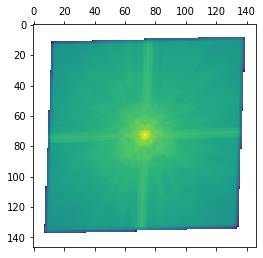

In [2]:

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
psf_filename = "psf_example.fits"
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

    
# data specifics
background_rms = .2  #  background noise per pixel (Gaussian rms value)
exp_time = 80.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 80  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required).


# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)


In [9]:
from lenstronomy.LensModel.lens_model import LensModel

def viz_lens(lens_model_list, kwargs_lens_list):
    # we set up a grid in coordinates and evaluate basic lensing quantities on it
    x_grid, y_grid = util.make_grid(numPix=100, deltapix=0.05)
    lensModel = LensModel(lens_model_list)

    # choice of source type
    source_x = 0.3
    source_y = 0.1

    # Sersic parameters in the initial simulation
    phi_G, q = 0.5, 0.8
    e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
    kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
    #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_source = [kwargs_sersic_source]
    source_model_class = LightModel(light_model_list=source_model_list)

    # lens light model
    phi_G, q = 0.9, 0.9
    e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
    kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
    lens_light_model_list = ['SERSIC_ELLIPSE']
    kwargs_lens_light = [kwargs_sersic_lens]
    lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    imageModel = ImageModel(data_class, psf_class, lensModel, source_model_class,
                                    lens_light_model_class, kwargs_numerics=kwargs_numerics)

    # generate image
    image_sim = imageModel.image(kwargs_lens_list, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
    poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
    bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
    image_sim = image_sim + bkg + poisson

    kwargs_data['image_data'] = image_sim
    data_class.update_data(image_sim)

    v_min = -4
    v_max = 2

    # f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
    # ax = axes
    # im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, extent=[0, 1, 0, 1])
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    # ax.autoscale(False)
    # plt.show()

    # # and here we compute the convergence at each pixel position
    x_coords, y_coords = data_class.pixel_coordinates
    kappa = lensModel.kappa(x_grid, y_grid, kwargs_lens_list)
    halos = util.array2image(np.log10(kappa))
    # plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
    # plt.show()

    return image_sim, halos

In [10]:
# define the lens model of the main deflector
main_halo_type = 'SIE'  # You have many other possibilities available. Check out the SinglePlane class!
kwargs_lens_main = {'theta_E': 1., 'e1': 0.1, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
lens_model_list = [main_halo_type, 'SHEAR']
kwargs_lens_list = [kwargs_lens_main, kwargs_shear]

non_subhalo_lens_model_list = copy.deepcopy(lens_model_list)
non_subhalo_kwargs_lens_list = copy.deepcopy(kwargs_lens_list)

subhalo_type = 'TNFW'  # We chose spherical NFW profiles, feel free to chose whatever you want.

# as an example, we render some sub-halos with a very simple distribution to be added on the main lens
num_subhalo = 10  # number of subhalos to be rendered
# the parameterization of the NFW profiles are:
# - Rs (radius of the scale parameter Rs in units of angles)
# - theta_Rs (radial deflection angle at Rs)
# - center_x, center_y, (position of the centre of the profile in angular units)

Rs_mean = 0.1
Rs_sigma = 0.1  # dex scatter
theta_Rs_mean = 0.05
theta_Rs_sigma = 0.1 # dex scatter
r_min, r_max = -2, 2

Rs_list = 10**(np.log10(Rs_mean) + np.random.normal(loc=0, scale=Rs_sigma, size=num_subhalo))
theta_Rs_list = 10**(np.log10(theta_Rs_mean) + np.random.normal(loc=0, scale=theta_Rs_sigma, size=num_subhalo))
center_x_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
center_y_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
for i in range(num_subhalo):
    lens_model_list.append(subhalo_type)
    kwargs_lens_list.append({'alpha_Rs': theta_Rs_list[i], 'Rs': Rs_list[i],
                             'center_x': center_x_list[i], 'center_y': center_y_list[i],
                            'r_trunc': 5*Rs_list[i]
                            })

/tmp/ipykernel_1047332/3820623397.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(lensed_img))


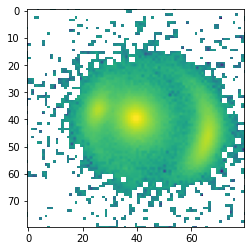

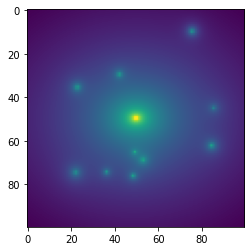

In [16]:
lensed_img, halos = viz_lens(lens_model_list, kwargs_lens_list)
plt.imshow(np.log(lensed_img))
plt.show()

plt.imshow(halos)
plt.show()

/tmp/ipykernel_1047332/3448187848.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(non_subhalo_lensed_img))


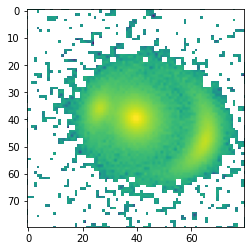

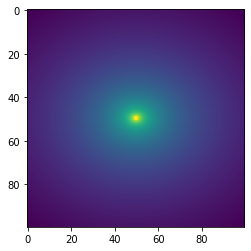

In [17]:
non_subhalo_lensed_img, non_subhalo_halos = viz_lens(non_subhalo_lens_model_list, non_subhalo_kwargs_lens_list)
plt.imshow(np.log(non_subhalo_lensed_img))
plt.show()

plt.imshow(non_subhalo_halos)
plt.show()

/tmp/ipykernel_1047332/2978969607.py:1: RuntimeWarning: invalid value encountered in log
  res = np.log(lensed_img) - np.log(non_subhalo_lensed_img)


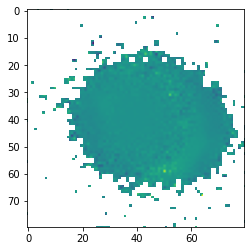

In [19]:
res = np.log(lensed_img) - np.log(non_subhalo_lensed_img)
plt.imshow(res)